In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import os

from scipy.stats import beta, binom, uniform

import seaborn as sns
sns.set() 

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

---

In [2]:
data= pd.read_csv(os.path.join('../data/processed/full_dataset.csv'))
data.head()

,county,avg_population,fips,avg_asthma_prevalence,num_asthma_cases,avg_number_ed_visits,DS_PM_pred,DS_PM_stdd,DS_O3_pred,DS_O3_stdd
0,Alameda,1662307.75,6001,8.466667,140742.056167,8642.0,0.298806,-0.327541,-1.472058,-1.655851
1,Alpine,1094.00,6003,9.933333,108.670667,0.0,-1.361941,-1.208717,1.015828,1.726385
2,Amador,38778.75,6005,9.933333,3852.022500,173.0,-0.290836,-0.258935,0.609425,0.193584
3,Butte,226113.00,6007,11.233333,25400.027000,882.0,0.525244,0.587070,0.288865,-0.020139
4,Calaveras,45651.50,6009,9.933333,4534.715667,187.8,0.001722,0.095965,0.752369,0.495479


### Defining the hierarchical model using PyMC

In [3]:
with pm.Model() as model:
    # priors for regression coefficients
    intercept = pm.Flat('intercept')
    pm_25_coeff = pm.Flat('pm_25_coeff')
    ozone_coeff = pm.Flat('oz_coeff')

    # covariates of linear predictor
    P = data['DS_PM_pred']
    O = data['DS_O3_pred']

    linear_pred = intercept + (pm_25_coeff * P) + (ozone_coeff * O)
    theta_i = pm.Deterministic('theta_i', pm.math.sigmoid(linear_pred))

    # binomial likelihood for the observed counts
    A_i = pm.Binomial('A_i',
                      n = data['avg_population'],
                      p = theta_i,
                      observed = data['num_asthma_cases'])

    # sample from the posterior
    trace = pm.sample(2000, tune=2000, chains=4, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, pm_25_coeff, oz_coeff]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


### Analyze Random Parameters

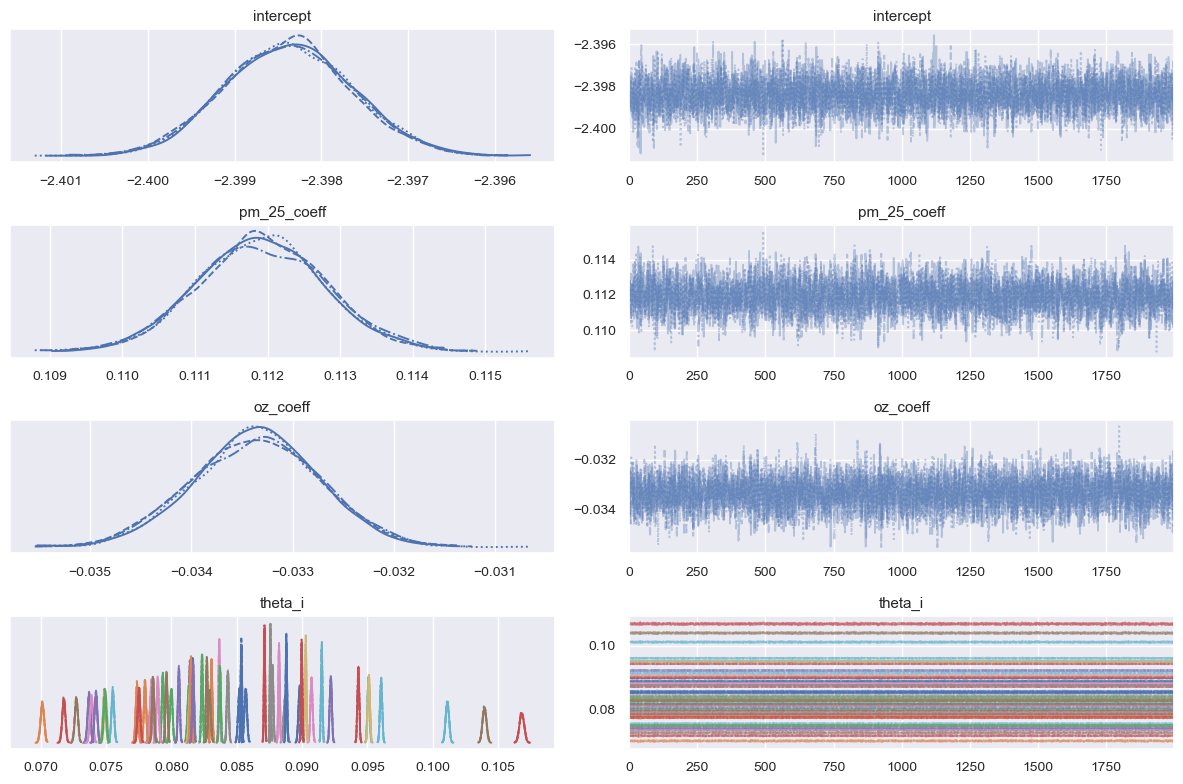

In [4]:
az.plot_trace(trace)
plt.tight_layout()

In [6]:
# random parameter means
posterior_intercept_mean = az.summary(trace, var_names=['intercept'])['mean'].values[0]
posterior_pm25_coeff_mean = az.summary(trace, var_names=['pm_25_coeff'])['mean'].values[0]
posterior_oz_coeff_mean = az.summary(trace, var_names=['oz_coeff'])['mean'].values[0]

# probability of ED visit per row
pm25_product = posterior_pm25_coeff_mean * data['DS_PM_pred']
oz_product = posterior_oz_coeff_mean * data['DS_O3_pred']
predictor = posterior_intercept_mean + pm25_product + oz_product
prob_ed_visit = 1 / (1 + np.exp(-predictor))

# add features to dataset
data['predicted_num_ed_visits'] = data['num_asthma_cases'] * prob_ed_visit
data['ed_visit_rate'] = data['avg_number_ed_visits'] / data['avg_population']
data['predicted_ed_visit_rate'] = data['predicted_num_ed_visits'] / data['avg_population']

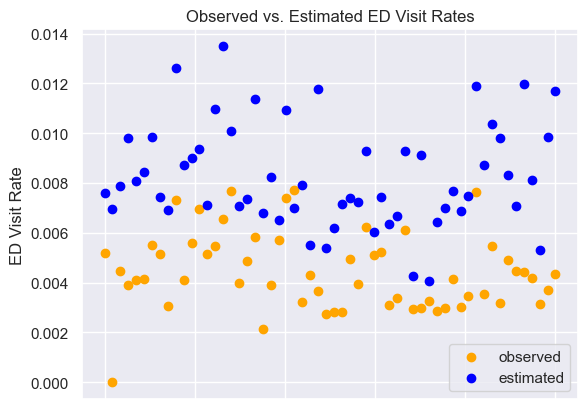

In [7]:
x = np.linspace(0, 1, len(data['county']))

plt.scatter(x=x,
            y=data['ed_visit_rate'],
            color='orange',
            label='observed')
plt.scatter(x=x,
            y=data['predicted_ed_visit_rate'],
            color='blue',
            label='estimated')
plt.legend();
plt.title('Observed vs. Estimated ED Visit Rates');
plt.xticks(visible=False);
plt.ylabel('ED Visit Rate');

---

### Analyze effect of PM2.5 and Ozone in linear relationship

In [8]:
az.summary(trace, var_names=['intercept', 'pm_25_coeff', 'oz_coeff'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-2.398,0.001,-2.400,-2.397,0.0,0.0,5003.0,5499.0,1.0
pm_25_coeff,0.112,0.001,0.110,0.113,0.0,0.0,3958.0,4558.0,1.0
oz_coeff,-0.033,0.001,-0.035,-0.032,0.0,0.0,5134.0,5659.0,1.0


---

### Posterior Predictive Check

Sampling: [A_i]


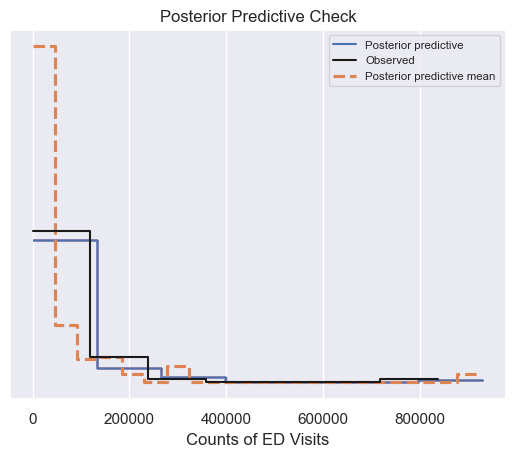

In [9]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc, num_pp_samples=100);
plt.title('Posterior Predictive Check');
plt.xlabel('Counts of ED Visits');

In [10]:
cols = ['county', 'avg_number_ed_visits', 'predicted_num_ed_visits', 'ed_visit_rate', 'predicted_ed_visit_rate']

data.sort_values(by='ed_visit_rate', ascending=False)[cols].head()

,county,avg_number_ed_visits,predicted_num_ed_visits,ed_visit_rate,predicted_ed_visit_rate
24,Modoc,68.4,61.899041,0.007712,0.006979
16,Lake,492.2,648.056395,0.007669,0.010098
47,Solano,3392.0,5271.598191,0.007641,0.011875
23,Merced,2020.4,2984.514800,0.007411,0.010947
9,Fresno,7235.2,12469.528380,0.007321,0.012617


In [11]:
data.sort_values(by='predicted_ed_visit_rate', ascending=False)[cols].head()

,county,avg_number_ed_visits,predicted_num_ed_visits,ed_visit_rate,predicted_ed_visit_rate
15,Kings,987.4,2035.166489,0.006546,0.013492
9,Fresno,7235.2,12469.528380,0.007321,0.012617
53,Tulare,2050.4,5545.800165,0.004428,0.011976
47,Solano,3392.0,5271.598191,0.007641,0.011875
27,Napa,511.2,1638.694135,0.003669,0.011763
